# E-Commerce Data Analysis

## Setup & Imports


In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load Data


In [2]:
items_df = pd.read_csv('items.csv')
customers_df = pd.read_csv('customers.csv')
orders_df = pd.read_csv('orders.csv')
order_items_df = pd.read_csv('order_item.csv')

In [3]:
i_df = items_df.copy()
c_df =  customers_df.copy()
o_df =  orders_df.copy()
oi_df =  order_items_df.copy()

---
# Data Cleaning

## 1. Handle Duplicate Data

### 1.1 Item Duplicates
- Same item name + same brand = duplicate
- Same item name with brand vs without brand = duplicate
- Keep item with more information, update associations in order_items


# Handle Duplicates
if the items have the same name and the same brand they are duplicates

In [4]:
def duplicate_items(items_df, order_items_df):
    df = items_df.copy()
    oi_df = order_items_df.copy()
    
    mapping = {}  # old_id -> kept_id
    ids_to_remove = set()
    
    # Group by item_name to find potential duplicates
    for name, group in df.groupby('item_name'):
        if len(group) < 2:
            continue
        
        duplicate_indices = []
        
        # Separate items with brand and without brand
        has_brand = group[group['item_brand'].notna()]
        no_brand = group[group['item_brand'].isna()]
        
        # Rule (i): Same name AND same brand (including both being null)
        # Group by brand (including NaN as a group)
        for brand, brand_group in group.groupby('item_brand', dropna=False):
            if len(brand_group) > 1:
                # Multiple items with same name and same brand = duplicates
                duplicate_indices.extend(brand_group.index.tolist())
        
        # Rule (ii): Same name, one with brand and one without
        if len(has_brand) > 0 and len(no_brand) > 0:
            # The no-brand item is considered a duplicate of the branded item
            # Add all items involved (both branded and non-branded) to duplicates
            for idx in no_brand.index:
                if idx not in duplicate_indices:
                    duplicate_indices.append(idx)
            for idx in has_brand.index:
                if idx not in duplicate_indices:
                    duplicate_indices.append(idx)
        
        if not duplicate_indices:
            continue
        
        dup_group = df.loc[duplicate_indices]
        null_counts = dup_group.isnull().sum(axis=1)
        
        min_nulls = null_counts.min()
        candidates = dup_group[null_counts == min_nulls]
        
        if len(candidates) > 1 and candidates['item_brand'].notna().any():
            best_idx = candidates[candidates['item_brand'].notna()].index[0]
        else:
            best_idx = candidates.index[0]
        
        kept_id = df.loc[best_idx, 'id']
        
        for idx in duplicate_indices:
            if idx != best_idx:
                old_id = df.loc[idx, 'id']
                if old_id not in ids_to_remove:
                    mapping[old_id] = kept_id
                    ids_to_remove.add(old_id)
    
    cleaned_items_df = df[~df['id'].isin(ids_to_remove)].reset_index(drop=True)
    
    oi_df['item_id'] = oi_df['item_id'].replace(mapping)
    
    
    return cleaned_items_df, oi_df, mapping


### 1.2 Customer Duplicates
- Same email address = duplicate
- Keep customer with more information, update associations in orders


In [5]:
# Apply the duplicate_items function
i_clean, oi_df_updated, mapping = duplicate_items(i_df, oi_df)

In [6]:
def duplicate_customers(customers_df, orders_df, order_items_df):
    customers = customers_df.copy()
    g = customers.groupby('email')

    mapping = {}
    to_be_removed = set()
    for email, group in g:
        if len(group) < 2:
            continue
            
        null_counts = group.isnull().sum(axis=1)
        best_rows = group[null_counts == null_counts.min()]
        
        if len(best_rows) > 1:
            best_rows = best_rows[best_rows['phone_number'].notnull()]
        if len(best_rows) > 1 and 'joining_date' in best_rows.columns:
            best_rows = best_rows.sort_values('joining_date', na_position='last')
        
        best_idx = best_rows.index[0]
        kept_id = customers.loc[best_idx, 'id']

        for idx in group.index:
            if idx == best_idx:
                continue
            old_id = customers.loc[idx, 'id']
            mapping[old_id] = kept_id
            to_be_removed.add(old_id)

    customers = customers[~customers['id'].isin(to_be_removed)]

    orders_df['customer_id'] = orders_df['customer_id'].replace(mapping)

    valid_customer_ids = set(customers['id'])
    orders_df = orders_df[orders_df['customer_id'].isin(valid_customer_ids)]

    valid_order_ids = set(orders_df['order_id'])
    order_items_df = order_items_df[order_items_df['order_id'].isin(valid_order_ids)]

    return customers, orders_df, order_items_df


## 2. Handle Missing Data
- **>5% missing:** Fill with default value (Unknown/median/date)
- **≤5% missing:** Remove the row
- **Mandatory column missing:** Remove the row
- **Cascade:** Adjust related datasets after removals


In [7]:
c_clean, o_clean, oi_clean=duplicate_customers(c_df,o_df,oi_df_updated)

In [8]:
mandatory_data = {
    'customers': ['id', 'email', 'first_name', 'last_name'],
    'orders' :['order_id', 'customer_id', 'order_date'],
    'order_items':['item_id', 'order_id', 'quantity'],
    'items':['id','item_name','item_category']
}

In [9]:
def handle_missing_data(df,dataset_name,mandatory_cols):
    df = df.copy()

    df = df.dropna(subset=mandatory_cols)

    missing_percent = df.isnull().sum() / len(df) * 100

    for col, pct in missing_percent.items():
        if pct == 0:
            continue
        if pct > 5:
            if df[col].dtype == 'O':  # object/string
                df[col] = df[col].fillna('Unknown')
            elif np.issubdtype(df[col].dtype, np.number):
                df[col] = df[col].fillna(df[col].median())
            elif np.issubdtype(df[col].dtype, np.datetime64):
                df[col] = df[col].fillna(pd.Timestamp('2020-01-01'))
            else:
                df[col] = df[col].fillna('Unknown')
            print(f"[{dataset_name}] Filled '{col}' ({pct:.1f}%)")
        else:
            # Drop rows with small missing percentage
            before = len(df)
            df = df.dropna(subset=[col])
            print(f"[{dataset_name}] Dropped {before - len(df)} rows with missing '{col}' ({pct:.1f}%)")

    return df

In [10]:
datasets = {
    'customers': c_clean,
    'orders': o_clean,
    'order_items': oi_clean,
    'items': i_clean
}

### Cascade Deletions
Remove orphaned records from related datasets


In [11]:
for name, df in datasets.items():
    datasets[name] = handle_missing_data(df, name, mandatory_data[name])

[customers] Filled 'gender' (10.6%)
[customers] Dropped 25 rows with missing 'age' (5.0%)
[customers] Filled 'joining_date' (12.2%)
[orders] Filled 'delivery_days' (12.4%)
[items] Filled 'stock_quantity' (9.5%)
[items] Dropped 2 rows with missing 'item_brand' (4.8%)


In [12]:
customers = datasets['customers']
orders = datasets['orders']
order_items = datasets['order_items']
items = datasets['items']

orders = orders[orders['customer_id'].isin(customers['id'])]

order_items = order_items[order_items['order_id'].isin(orders['order_id'])]

order_items = order_items[order_items['item_id'].isin(items['id'])]


datasets['customers'] = customers
datasets['orders'] = orders
datasets['order_items'] = order_items
datasets['items'] = items

---
# Data Analysis

## 1. Explore Customers Dataset


# Data analysis

In [13]:
c_df = datasets['customers'].copy()
o_df= datasets['orders'].copy()
oi_df = datasets['order_items'].copy()
i_df = datasets['items'].copy()

### 1a. Count customers by gender


In [14]:
def gender_plot(df):
    plot_df = df.copy()
    plot_df = plot_df.value_counts('gender').reset_index()
    plt.figure(figsize=(12,6))
    sns.barplot(x='gender',y='count',data=plot_df)
    plt.xticks(rotation=45)
    return plot_df


,gender,count
0,Female,193
1,Male,187
2,Unknown,51
3,Genderfluid,12
4,Agender,10
5,Non-binary,7
6,Polygender,6
7,Genderqueer,5
8,Bigender,4


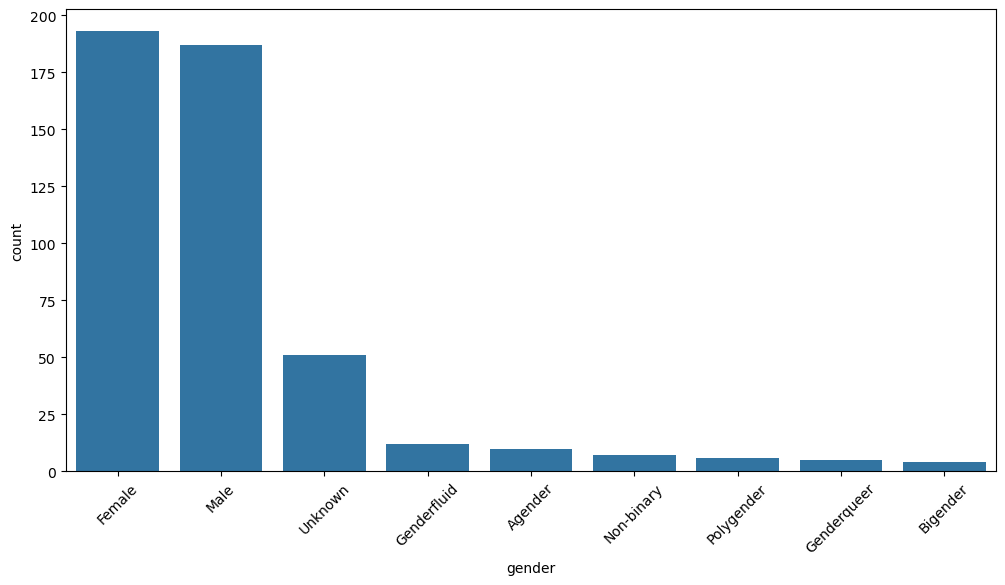

In [15]:
gender_plot(c_df)

### 1b. Age distribution histogram


In [16]:
def age_histogram(df):
    plot_df = c_df.copy()
    sns.histplot(data=plot_df,x='age')


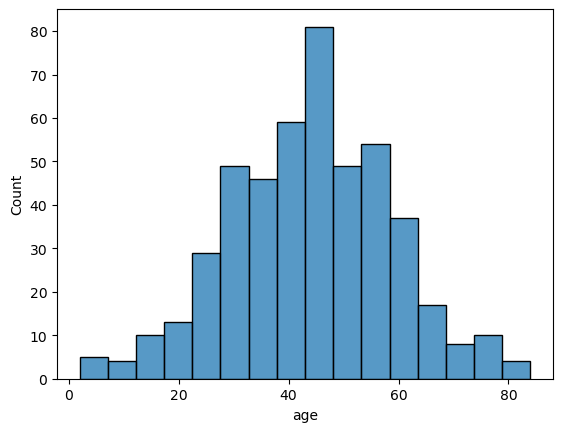

In [17]:
age_histogram(c_df)

### 1c. Year with most customer joins


In [18]:
c_df['joining_date'] = pd.to_datetime(c_df['joining_date'],errors='coerce')

In [19]:
def year_with_most_joins(df):
    plot_df = df.copy()
    plot_df['year'] = plot_df['joining_date'].dt.year
    g = plot_df.groupby('year')['id'].count().reset_index()
    g.columns = ['year','count']
    top_row = g.loc[g['count'].idxmax()]
    top_year = top_row['year']
    top_count = top_row['count']
    return top_year,top_count
    

### 1d. Customer joining trend (2020-2023)


In [20]:
year,count = year_with_most_joins(c_df)
print(f"The year with most joins is:{year} with a count of:{count}")

The year with most joins is:2022.0 with a count of:156.0


In [21]:
def join_count_plot(df):
    plot_df = df.copy()
    plot_df['year'] = plot_df['joining_date'].dt.year
    g = plot_df.groupby('year')['id'].count().reset_index(name='count')
    sns.lineplot(x='year',y='count',data=g)
    plt.xticks(g['year'])


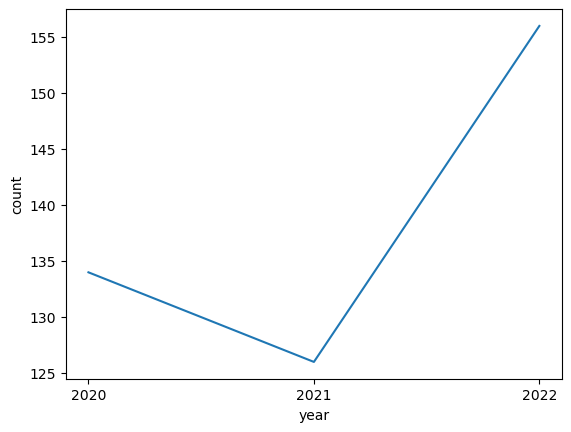

In [22]:
join_count_plot(c_df)

### 1e. Month with most customer joins


# Answer to D: we dont see a consistent increace/decrease, but we do see an overall increase

In [23]:
def month_with_most_joins(df):
    plot_df = df.copy()
    plot_df['month'] = plot_df['joining_date'].dt.month
    plot_df = plot_df.groupby('month')['id'].count().reset_index(name='count')
    sns.lineplot(x='month',y='count',data=plot_df)


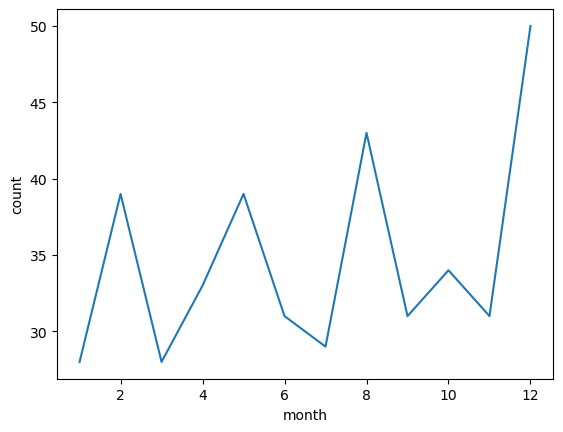

In [24]:
month_with_most_joins(c_df)

---
## 2. Explore Items Dataset


# From the line plot we can see the the month with the most joins is December

### 2a. Count items by category (Pie Chart)


# Items

In [25]:
def pie_chart_item_category(df):
    plot_df = df.copy()
    plot_df =plot_df.groupby('item_category').size().reset_index(name='count')
    plt.pie(plot_df['count'],labels=plot_df['item_category'],autopct='%1.1f%%')
    plt.title("Pie Chart - Items category")
    

### 2b. Items with max and min stock quantity


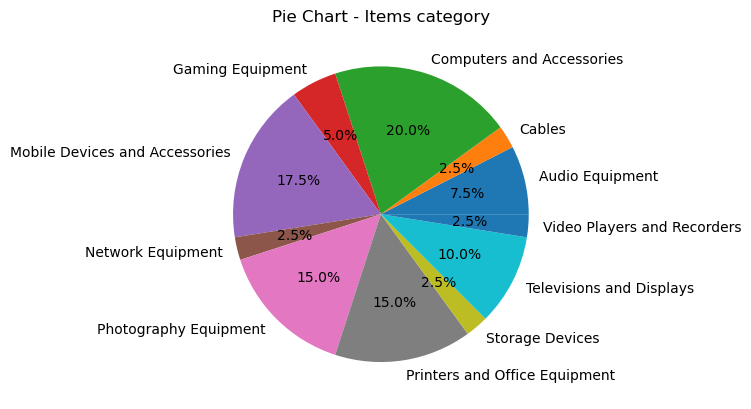

In [26]:
pie_chart_item_category(i_df)

In [27]:
def items_with_min_max_quantity(df):
    plot_df = df.copy()
    plot_df.dropna(subset=['stock_quantity'])
    large = plot_df.nlargest(1,'stock_quantity')
    small = plot_df.nsmallest(1,'stock_quantity')
    return pd.concat([large,small])

### 2c. Mean stock quantity


In [28]:
items_with_min_max_quantity(i_df)

,id,item_name,item_category,item_price,stock_quantity,item_brand,item_availability
7,9,Speaker,Audio Equipment,4471.27,1360.0,Toshiba,True
33,35,Wi-Fi Router,Network Equipment,3812.53,14.0,Microsoft,True


In [29]:
def calc_mean_quantity(df):
    plot_df = df.copy()
    plot_df.dropna(subset=['stock_quantity'])
    return plot_df['stock_quantity'].mean()

In [30]:
calc_mean_quantity(i_df)

np.float64(734.875)

---
## 3. Explore Orders Dataset

### 3a. Count customers by number of purchases


In [47]:
def customers_by_num_of_purchases(df):
    plot_df = df.copy()
    plot_df = df.groupby('customer_id').size().value_counts().sort_index().reset_index()
    plot_df.columns = ['num_purchases','num_customers']
    sns.barplot(x='num_purchases',y='num_customers',data=plot_df)
    return plot_df


,num_purchases,num_customers
0,1,155
1,2,99
2,3,44
3,4,6
4,5,2


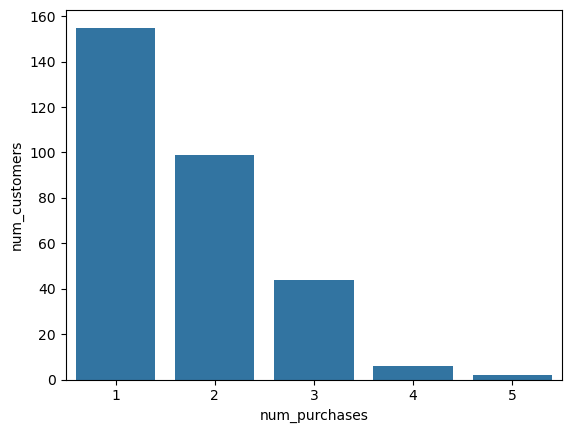

In [48]:
customers_by_num_of_purchases(o_df)

In [63]:
def top_five_customers(o_df,c_df):
    o_df_copy = o_df.copy()
    c_df_copy = c_df.copy()
    o_df_copy = o_df_copy.groupby('customer_id').size().reset_index(name='order_count')
    top5 = o_df_copy.nlargest(5,'order_count')
    return pd.merge(top5, c_df_copy, left_on='customer_id', right_on='id')
    

In [64]:
top_five_customers(o_df,c_df)

,customer_id,order_count,id,first_name,last_name,gender,age,nationallity,joining_date,phone_number,email
0,59.0,5,59,Merill,Lacroutz,Male,40.0,Isreal,2022-04-11,988-997-5910,mlacroutz1m@ft.com
1,138.0,5,138,Ellary,Ledner,Unknown,63.0,Peru,NaT,343-500-4046,eledner3t@latimes.com
2,151.0,4,151,Giorgio,Mence,Unknown,47.0,Isreal,2020-02-16,876-504-5081,gmence46@statcounter.com
3,204.0,4,204,Sharon,Wilby,Female,26.0,Peru,NaT,235-951-1329,swilby5n@dailymail.co.uk
4,237.0,4,237,Brunhilda,Glazebrook,Unknown,54.0,Spain,2020-09-23,832-342-5526,bglazebrook6k@ibm.com


In [ ]:
def payment_methods(df):
    